In [71]:
import torch
from pathlib import Path

import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm


from diffdrr.data import read
from diffdrr.drr import DRR

import matplotlib.pyplot as plt

In [72]:
subject = read("/data/vision/polina/scratch/walnut/data/Walnut1/gt.nii.gz")

In [262]:
def get_source_target_vec(vecs):
    projs_rows = 972  # Image height
    projs_cols = 768  # Image width

    # projs_rows = 768   # Image height
    # projs_cols = 972  # Image width


    # vecs = np.loadtxt(f'/home/hossein/scratch/walnut_data/walnut/data/Walnut{walnut_id}/Projections/tubeV{tube}/scan_geom_corrected.geom')
    sources = []
    targets = []
    for idx in range(len(vecs)):
        src = vecs[idx, :3]  # X-ray source
        det = vecs[idx, 3:6]  # Center of the detector plane
        u = vecs[idx, 6:9]  # Basis vector one of the detector plane
        v = vecs[idx, 9:12]  # Basis vector two of the detector plane

        src = torch.from_numpy(src).to(torch.float32)
        det = torch.from_numpy(det).to(torch.float32)
        u = torch.from_numpy(u).to(torch.float32)
        v = torch.from_numpy(v).to(torch.float32)

        # Create a canonical basis for the detector plane
        rows = torch.arange(-projs_rows // 2, projs_rows // 2) + 0.5 if projs_rows % 2 == 0 else 1.0
        cols = torch.arange(-projs_cols // 2, projs_cols // 2) + 0.5 if projs_cols % 2 == 0 else 1.0

        # Change of basis to u and v from the dataset
        i, j = torch.meshgrid(rows, cols, indexing="ij")
        x = torch.einsum("ij, n -> ijn", j, -u)
        y = torch.einsum("ij, n -> ijn", i, v)

        # Move the center of the detector plane to `det`
        source = src
        target = det + x + y
        source = source.expand(target.shape)
        sources.append(source.flip([1,2]))
        targets.append(target.flip([1,2]))
    return sources, targets

In [263]:
def trafo(image):
    """
    A transformation to apply to each image. Converts an image from the
    raw scanner output to the form described by the projection geometry.
    """
    return np.transpose(np.flipud(image))


def load(
    datapath,
    proj_rows,
    proj_cols,
    subsample,
    orbits_to_recon=[1, 2, 3],
    geometry_filename="scan_geom_corrected.geom",
    dark_filename="di000000.tif",
    flat_filenames=["io000000.tif", "io000001.tif"],
):
    """Load and preprocess raw projection data."""

    # Create a numpy array to geometry projection data
    projs = np.zeros((proj_rows, 0, proj_cols), dtype=np.float32)

    # And create a numpy array to projection geometry
    vecs = np.zeros((0, 12), dtype=np.float32)
    orbit = range(0, 1200, subsample)
    n_projs_orbit = len(orbit)

    # Projection file indices, reversed due to portrait mode acquisition
    projs_idx = range(1200, 0, -subsample)

    # Read the images and geometry from each acquisition
    for orbit_id in orbits_to_recon:

        # Load the scan geometry
        orbit_datapath = datapath / f"tubeV{orbit_id}"
        vecs_orbit = np.loadtxt(orbit_datapath / f"{geometry_filename}")
        vecs = np.concatenate((vecs, vecs_orbit[orbit]), axis=0)

        # Load flat-field and dark-fields
        dark = trafo(imageio.imread(orbit_datapath / dark_filename))
        flat = np.zeros((2, proj_rows, proj_cols), dtype=np.float32)
        for idx, fn in enumerate(flat_filenames):
            flat[idx] = trafo(imageio.imread(orbit_datapath / fn))
        flat = np.mean(flat, axis=0)

        # Load projection data directly on the big projection array
        projs_orbit = np.zeros((n_projs_orbit, proj_rows, proj_cols), dtype=np.float32)
        for idx, fn in enumerate(tqdm(projs_idx, desc=f"Loading images (tube {orbit_id})")):
            projs_orbit[idx] = trafo(
                imageio.imread(orbit_datapath / f"scan_{fn:06}.tif")
            )

        # Preprocess the projection data
        projs_orbit -= dark
        projs_orbit /= flat - dark
        np.log(projs_orbit, out=projs_orbit)
        np.negative(projs_orbit, out=projs_orbit)

        # Permute data to ASTRA convention
        projs_orbit = np.transpose(projs_orbit, (1, 0, 2))
        projs = np.concatenate((projs, projs_orbit), axis=1)
        del projs_orbit

    projs = np.ascontiguousarray(projs)
    return projs, vecs

In [264]:
dir = Path('/data/vision/polina/scratch/walnut/data/Walnut1/Projections/')
projs, vecs = load(dir, 972, 768, 600, orbits_to_recon=[2])

<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
Loading images (tube 2): 100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 172.90it/s]

In [265]:
s, t = get_source_target_vec(vecs)
s = torch.stack(s)
t = torch.stack(t)

In [266]:
s.shape

torch.Size([2, 972, 768, 3])

In [267]:
s = s.view(2, -1 ,3)
t = t.view(2, -1 ,3)

In [268]:
s.shape

torch.Size([2, 746496, 3])

In [93]:
s[0].flip([1,2] ).shape, s[0].shape

(torch.Size([972, 768, 3]), torch.Size([972, 768, 3]))

In [94]:
s = s.flip([1,2])
t = t.flip([1,2])

In [118]:
idx = 11

In [269]:
drr = DRR(subject, sdd=199.006188, height=768, width=972, delx=0.074800, renderer='trilinear').cuda()
# s = s[0].flip([1,2])
# t = t[0].flip([1,2])
s_t = drr.affine_inverse(s.cuda())
t_t = drr.affine_inverse(t.cuda())

img_t = drr.renderer(
    subject.density.data.squeeze(0).cuda(),
    s_t,
    t_t,
    n_points=500
).cpu()

drr_img = img_t.squeeze(1)
gt_img = projs[:, 1,:]
dr_img_t = img_t.view(2, -1, 972, 768)

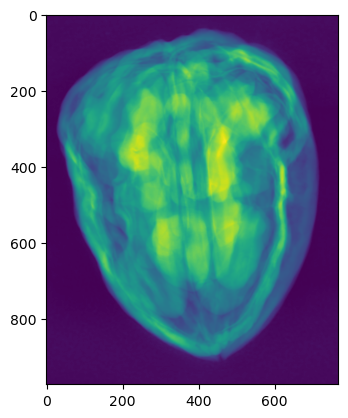

In [272]:
plt.imshow(dr_img_t[0,0])

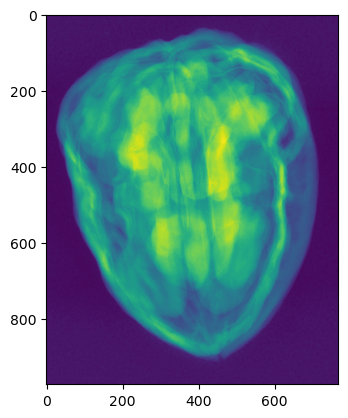

In [275]:
plt.imshow(projs[:, 0,:])

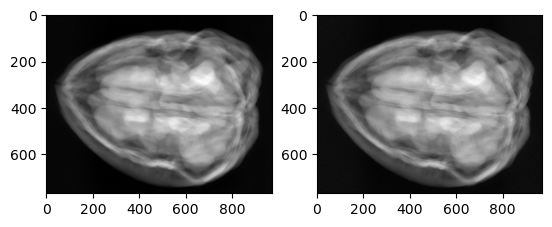

In [256]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(dr_img_t[0,0].T.flip(1).flip(0), cmap='gray')
axs[1].imshow(trafo(projs[:, -1,:]), cmap='gray')
plt.show()

In [81]:
drr_img.min(), drr_img.max(), gt_img.min(), gt_img.max()

(tensor(1.0978), tensor(252.3239), -0.030901583, 1.0481311)

In [82]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-10)

The image here is blurry, showing that the walnuts are not perfectly aligned.

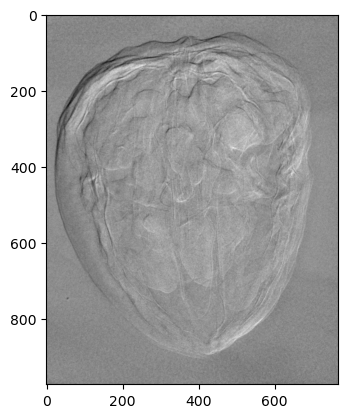

In [121]:
plt.imshow(normalize(drr_img) - normalize(gt_img), cmap='gray')